In [84]:
from commonFunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


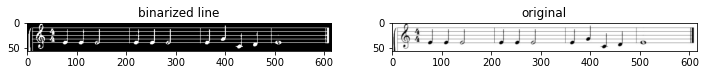

(57, 615)


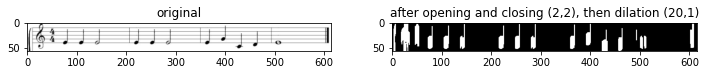

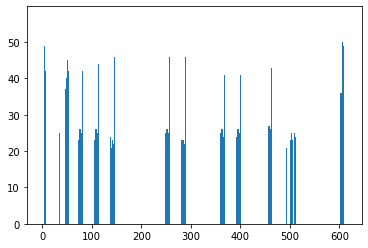

[28, 47, 74, 107, 139, 218, 250, 282, 361, 393, 427, 457]


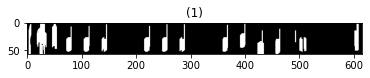

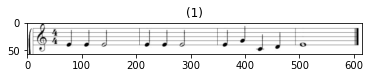

In [85]:
# load line & template as gray images and binarize them
img = (cv.imread("imgs/line.png",0)).astype(np.uint8)
original = img.copy()
template = (cv.imread("imgs/template.png",0)).astype(np.uint8)
img = (img <= threshold_otsu(img)).astype(np.uint8)
img = img.astype(np.uint8)
template = (template <= threshold_otsu(template)).astype(np.uint8)
show_images([img,original],["binarized line","original"])
print(img.shape)

kernal = np.ones((2,2)).astype(np.uint8)
img = opening(img,kernal)
img = closing(img,kernal)
kernal = np.ones((20,1)).astype(np.uint8)
img = binary_dilation(img,kernal).astype(np.uint8)
show_images([original,img],["original","after opening and closing (2,2), then dilation (20,1)"])

# perform vertical-histogram-projection and display it
his = cv.reduce(img,0,cv.REDUCE_SUM,dtype=cv.CV_32S)[0]
plt.bar(np.arange(len(his)),his)
plt.show()

# extract spliting positions
locs = []
last = []
for i in range(len(his)):
    if np.all(his[i:i+8]):
        locs.append(i)
for i in range(len(locs)-1):
    if locs[i+1]-locs[i] > 1:
        last.append(locs[i])
print(last)

# undo the morphological operations done
show_images([img])
img = binary_erosion(img,kernal).astype(np.uint8)
kernal = np.ones((2,2)).astype(np.uint8)
img = closing(img).astype(np.uint8)

# # extract img as parts
res = []
for pos in last:
    # rr,cc = line(0,pos,55,pos)
    # original[rr,cc] = 1
    res.append(original[:,pos-7:pos+9])
show_images([original])

Best angle: 28.0


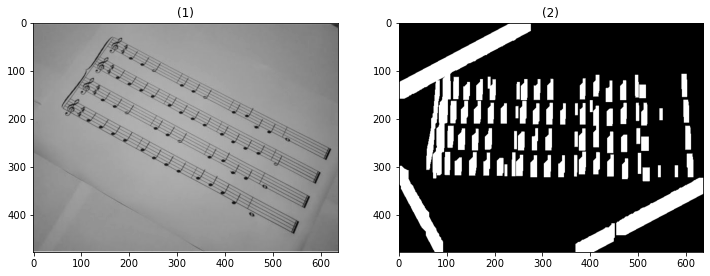

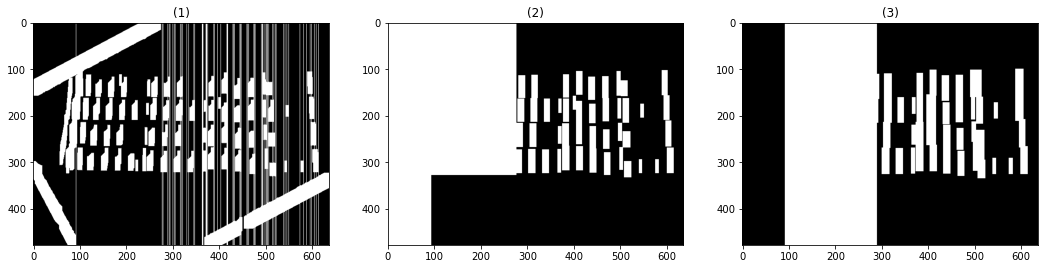

35


In [98]:
import skimage as sk
def binarize(img,block_size = 35):
    t = sk.filters.threshold_local(img, block_size, offset=10)
    img_b = img < t
    return img_b

def changeToInt(img):
    img = img.astype(np.float64) / np.max(img) 
    img = 255 * img 
    img = img.astype(np.uint8)
    return img

def deskew(img,delta=1,limit=60):
    def find_score(arr, angle):
        data = sp.ndimage.interpolation.rotate(arr, angle, reshape=False, order=0)
        hist = np.sum(data, axis=1)
        score = np.sum((hist[1:] - hist[:-1]) ** 2)
        return hist, score
    delta = .5
    limit = 30
    angles = np.arange(-limit, limit+delta, delta)
    scores = []
    for angle in angles:
       hist, score = find_score(img, angle)
       scores.append(score)
    best_score = max(scores)
    best_angle = angles[scores.index(best_score)]
    print('Best angle: '+str(best_angle))
    #correct skew
    img_n = sp.ndimage.interpolation.rotate(img, best_angle, reshape=False, order=0)
    return img_n


img = cv.imread("imgs/test3.png",0)
res = img.copy()
original = img.copy()
res = changeToInt(res)

res = binarize(res)
# tmp = res.copy()
res = deskew(res)
se = np.ones((1,int(img.shape[1]*0.1)))
se2 = np.array([[1,0,1],[0,0,0],[1,0,1]])
se3 = np.array([[0,1,0],[0,1,0],[0,1,0]])
# res = erosion(res)
res = opening(res)
# res = median(res)
for i in range(9):
    res = erosion(res)
    res = dilation(res,se2)
    res = dilation(res,se3)
    # res = median(res)
res = dilation(res,se2)
res = dilation(res,se3)
# res = skeletonize(res == True)
    # res = erosion(res)
# res = dilation(res)
# res = np.uint8(equalize_adapthist(res,kernel_size=img.shape[0]//8,clip_limit=0.1)*255)
# res = gaussian(res)
# res = changeToInt(res)
# res = sobel_v(res)
# res = changeToInt(res)

# res = threshold_local(res,block_size=3)
# res = res > threshold_otsu(res)
# res = dilation(res).astype(np.uint8)
# res = dilation(res).astype(np.uint8)
# print(res)
show_images([img,res])
# res = changeToInt(res)
# his = cv.reduce(res,0,cv.REDUCE_SUM,dtype=cv.CV_32S)[0]
# plt.bar(np.arange(len(his)),his)
# plt.show()

bounding_boxes = find_contours(res,0.8,fully_connected='high')
newImg = np.zeros(res.shape)
lines = []
cnt = 0
for box in bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = [ np.min(box[:,1]),np.max(box[:,1]),np.min(box[:,0]),np.max(box[:,0]) ]
    Ymin -= 2
    Ymax += 2
    ar =  (Xmax-Xmin)/(Ymax-Ymin)
    if ( ( ar <= 1)):
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=newImg.shape)
        rr = rr.astype(int)
        cc = cc.astype(int)
        newImg[rr, cc] = 1
        cnt += 1

bounding_boxes = find_contours(newImg,0.8,fully_connected='high')
newImg2 = np.zeros(newImg.shape)
lines = []
cnt = 0
for box in bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = [ np.min(box[:,1]),np.max(box[:,1]),np.min(box[:,0]),np.max(box[:,0]) ]
    Ymin -= 2
    Ymax += 2
    ar =  (Xmax-Xmin)/(Ymax-Ymin)
    if ( ( ar <= 1)):
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=newImg.shape)
        rr = rr.astype(int)
        cc = cc.astype(int)
        newImg2[rr, cc] = 1
        cnt += 1
        rr,cc = line(0,int(Xmax),res.shape[0]-1,int(Xmax))
        rr = rr.astype(int)
        cc = cc.astype(int)
        res[rr,cc]=1
        rr,cc = line(0,int(Xmin),res.shape[0]-1,int(Xmin))
        rr = rr.astype(int)
        cc = cc.astype(int)
        res[rr,cc]=1

show_images([res,newImg,newImg2])
print(cnt)
# extract spliting positions
# locs = []
# last = []
# for i in range(len(his)):
#     if his[i] < 5 and his[i+1] < 5:
#         locs.append(i)
# for i in range(len(locs)-1):
#     if locs[i+1]-locs[i] > 1:
#         last.append(locs[i])
# print(last)

# res = erosion(res).astype(np.uint8)
# res = erosion(res).astype(np.uint8)

# # extract img as parts
# res_ = []   
# for pos in last:
#     res_.append(original[:,pos-11:pos+9])
    # rr,cc = line(0,pos-11,55,pos-11)
    # original[rr,cc] = 1
# show_images([original])
# show_images(res_)

Best angle: 28.0


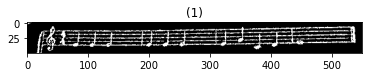

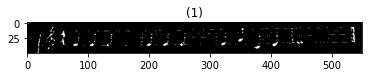

In [61]:
import cv2 as cv
import scipy as sp

def deskew(img,delta=1,limit=60):
    def find_score(arr, angle):
        data = sp.ndimage.interpolation.rotate(arr, angle, reshape=False, order=0)
        hist = np.sum(data, axis=1)
        score = np.sum((hist[1:] - hist[:-1]) ** 2)
        return hist, score
    delta = .5
    limit = 30
    angles = np.arange(-limit, limit+delta, delta)
    scores = []
    for angle in angles:
       hist, score = find_score(img, angle)
       scores.append(score)
    best_score = max(scores)
    best_angle = angles[scores.index(best_score)]
    print('Best angle: '+str(best_angle))
    #correct skew
    img_n = sp.ndimage.interpolation.rotate(img, best_angle, reshape=False, order=0)
    return img_n

def binarize(img,block_size = 35):
    t = threshold_local(img, block_size, offset=10)
    img_b = img < t
    return img_b

img = cv.imread("imgs/test3.png",0)
original = img.copy()
img = binarize(img)
img = deskew(img)
show_images([img[110:160,60:610]])
img = img[110:160,60:610].astype(np.uint8)

# ------------------------------------------------------------------------

img = erosion(img)
# img = dilation(img)
# kernal = np.ones((2,2)).astype(np.uint8)
# img = opening(img,kernal)
# img = closing(img,kernal)
kernal = np.ones((10,1)).astype(np.uint8)
# img = binary_dilation(img,kernal).astype(np.uint8)
show_images([img])

# perform vertical-histogram-projection and display it
# his = cv.reduce(img,0,cv.REDUCE_SUM,dtype=cv.CV_32S)[0]
# plt.bar(np.arange(len(his)),his)
# plt.show()

# # extract spliting positions
# locs = []
# last = []
# for i in range(len(his)):
#     if np.all(his[i:i+8]):
#         locs.append(i)
# for i in range(len(locs)-1):
#     if locs[i+1]-locs[i] > 1:
#         last.append(locs[i])
# print(last)

# # undo the morphological operations done
# show_images([img])
# img = binary_erosion(img,kernal).astype(np.uint8)
# kernal = np.ones((2,2)).astype(np.uint8)
# img = closing(img).astype(np.uint8)

# # # extract img as parts
# res = []
# for pos in last:
#     # rr,cc = line(0,pos,55,pos)
#     # original[rr,cc] = 1
#     res.append(img[:,pos-7:pos+9])
# show_images([img])